## Tutorial 3: Choosing hyperparameters for  augmented Lagrangian optimization.

Here, we will run the same EPI optimization as in Tutorials 1 and 2, but with different choices of augmented Lagrangian (AL) optimization hyperparameters. The stochastic constrained objective of EPI is optimized using an AL methodology elaborated below.  The hyperparameters of this optimization have default values, but it is useful to learn how to modify these choices for your application.  This tutorial should give an idea of what hyperparameters are suitable for a given EPI distribution, and how to design a hyperparameter search.

Throughout the tutorial, please refer to the API documentation at [https://epi.readthedocs.io/en/latest/API.html](https://epi.readthedocs.io/en/latest/API.html).

First, we'll run the setup code from Tutorials 1 and 2 right up until we invoke the EPI method.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import tensorflow as tf
# Mac OS jupyter kernel dies without.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from epi.models import Model, Parameter
import time

matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

# 1. Define the model.
lb, ub = -10., 10.
a11 = Parameter("a11", 1, lb=lb, ub=ub)
a12 = Parameter("a12", 1, lb=lb, ub=ub)
a21 = Parameter("a21", 1, lb=lb, ub=ub)
a22 = Parameter("a22", 1, lb=lb, ub=ub)
name = "lds_2D"
params = [a11, a12, a21, a22]
M = Model(name, params)

# 2. Define the emergent property.
def linear2D_eig(a11, a12, a21, a22):
    tau = 1.0
    c11 = a11 / tau
    c12 = a12 / tau
    c21 = a21 / tau
    c22 = a22 / tau

    
    # Quadratic formula.
    real_term = 0.5 * (c11 + c22)
    complex_term = 0.5 * tf.sqrt(
        tf.complex(tf.square(c11 + c22) - 4.0 * (c11 * c22 - c12 * c21), 0.0)
    )
    real_lambda = real_term + tf.math.real(complex_term)
    imag_lambda = tf.math.imag(complex_term)

    T_x = tf.concat(
        (
            real_lambda,
            imag_lambda,
            tf.square(real_lambda - 0.),
            tf.square(imag_lambda - (2. * np.pi)),
        ),
        axis=1,
    )
    return T_x
M.set_eps(linear2D_eig)
mu = np.array([0.0, 2 * np.pi, 0.5**2, (0.2 * np.pi)**2])

### EPI optimization

The objective of EPI is

$$\underset{q_\theta \in Q}{\mathrm{arg max}} \hspace{.2cm} H(q_\theta(z))$$

$$\text{s.t.} \mathbb{E}_{z \sim q_\theta}[ \mathbb{E}_{x \sim p(x \mid z)}[T(x)]] = \mu.$$

$q_\theta$ is optimized with the following augmented Lagrangian loss function:

$$L(\theta; \eta, c) = -H(q_\theta) + \eta^\top R(\theta) + \frac{c}{2}||R(\theta)||^2$$

where $R(\theta) = \mathbb{E}_{z \sim q_\theta}[ \mathbb{E}_{x \sim p(x \mid z)}[T(x)]] - \mu$ is the vector of constraint violation.  This objective is optimized for $\eta_k$ and $c_k$, which are updated for each of the `K` augmented Lagrangian optimization epochs, which proceed for `num_iters` iterations until convergence.  Convergence (stochastic constraint adherance) is evaluated using a series of hypothesis tests  for each constraint.  The details are elaborated below.

#### Update rule for $\eta_k$ and $c_k$
$\eta_1$ is initialized to the zero vector, and $c_1$ is initialized to `c0`.  Following each augmented Lagrangian epoch, they are updated according to a criteria parameterized by hyperparameter $\gamma$ (optional parameter `gamma` of `Model.epi`) and by an amount parameterized by hyperparameter $\beta$ (optional parameter `beta` of `Model.epi`).

**Criteria**:

The p-value ($p$) of $\mathbb{E}[|R(\theta_{k})|] > \gamma \mathbb{E}[|R(\theta_{k-1})|]$ is computed.

**Update**:

Always, $\eta_{k+1} = \eta_k + c_k$.

With probability $1-p$, $c_{k+1} = \beta c_k$.

#### `c0` is very important!

The initialization of $c_1$ to `c0` is the most critical hyperparamter choice of the augmented Lagrangian.  It defines the initial tradeoff between constraint satisfaction and entropic growth of EPI, and will only increasingly weight constraint satisfaction during later epochs.

A general rule of thumb for well-behaved EPI optimizations is that an initial period of stable entropic growth should cover the modes of the distribution you wish to uncover.  This initial period of stable entropic growth should then be followed by iterative changes at each epoch until the constraints are satisfied.

Let's take a look at the 2D LDS oscillation EPI optimization at various choices of `c0`.

In [2]:
c0s = [1e-5, 1e-4, 1e-3, 1e-2]
q_thetas = []
opt_datas = []

for i in range(len(c0s)):
    c0 = c0s[i]
    # Run EPI with coupling flow.
    print('Running EPI with c0 = %.2E.' % c0)
    q_theta, opt_data, _, _ = M.epi(
        mu,
        c0=c0,
        K=20,
        stop_early = True,
    )
    q_thetas.append(q_theta)
    opt_datas.append(opt_data)
    

Running EPI with c0 = 1.00E-05.
Initializing D4_C3_affine_L2_U50_PA_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/epi/lds_2D/48988ad4eb43922fde8a7438dc0c7e5f/D4_C3_affine_L2_U50_PA_rs1/bad59598253d74d26098ac5705f713e1/N500_lr1.00E-03_c0=1.00E-05_gamma2.50E-01_beta4.00E+00.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 0,i=   0): cost  1.44E+03, H  1.14E+01, |R|^2 1.45E+03, 0.00E+00 s/it
EPI(k= 1,i=1000): cost -1.20E+01, H  1.20E+01, |R|^2 2.30E+03, 3.26E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 2,i=1000): cost -1.19E+01, H  1.20E+01, |R|^2 2.31E+03, 3.40E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 3,i=1000): cost -1.17E+01, H  1.19E+01, |R|^2 1.80E+03, 3.23E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 4,i=1000): cost -1.12E+01, H  1.18E+01, |R|^2 9.12E+02, 3.27E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 5,i=1000): cost -1.03E+01, H  1.12E+01, |R|^2 2.98E+02, 3.25E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 6,i=1000): cost -9.45E+00, H  1.03E+01, |R|^2 5.46E+01, 3.66E-03 s/it
EPI(k= 7,i=1000): cost -9.03E+00, H  9.73E+00, |R|^2 1.84E+01, 3.82E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 8,i=1000): cost -8.73E+00, H  9.59E+00, |R|^2 1.11E+01, 4.26E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 9,i=1000): cost -8.28E+00, H  8.88E+00, |R|^2 1.90E+00, 3.95E-03 s/it
EPI(k=10,i=1000): cost -7.94E+00, H  8.73E+00, |R|^2 1.49E+00, 3.82E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=11,i=1000): cost -7.65E+00, H  8.17E+00, |R|^2 3.17E-01, 4.22E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=12,i=1000): cost -7.31E+00, H  7.73E+00, |R|^2 8.38E-02, 4.58E-03 s/it
EPI(k=13,i=1000): cost -7.34E+00, H  7.59E+00, |R|^2 1.74E-02, 3.58E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=14,i=1000): cost -7.18E+00, H  7.46E+00, |R|^2 1.46E-02, 3.66E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=15,i=1000): cost -6.90E+00, H  7.16E+00, |R|^2 7.26E-03, 3.49E-03 s/it
Running EPI with c0 = 1.00E-04.
Initializing D4_C3_affine_L2_U50_PA_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/epi/lds_2D/48988ad4eb43922fde8a7438dc0c7e5f/D4_C3_affine_L2_U50_PA_rs1/bad59598253d74d26098ac5705f713e1/N500_lr1.00E-03_c0=1.00E-04_gamma2.50E-01_beta4.00E+00.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 0,i=   0): cost  1.70E+03, H  1.15E+01, |R|^2 1.71E+03, 0.00E+00 s/it
EPI(k= 1,i=1000): cost -1.19E+01, H  1.20E+01, |R|^2 1.87E+03, 3.62E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 2,i=1000): cost -1.15E+01, H  1.18E+01, |R|^2 1.10E+03, 3.97E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 3,i=1000): cost -1.07E+01, H  1.14E+01, |R|^2 4.02E+02, 3.90E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 4,i=1000): cost -9.80E+00, H  1.07E+01, |R|^2 1.14E+02, 3.76E-03 s/it
EPI(k= 5,i=1000): cost -9.28E+00, H  1.02E+01, |R|^2 4.42E+01, 3.51E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 6,i=1000): cost -8.90E+00, H  9.62E+00, |R|^2 1.23E+01, 3.73E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 7,i=1000): cost -8.44E+00, H  9.10E+00, |R|^2 3.61E+00, 4.07E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 8,i=1000): cost -7.91E+00, H  8.57E+00, |R|^2 1.03E+00, 3.53E-03 s/it
EPI(k= 9,i=1000): cost -7.62E+00, H  8.34E+00, |R|^2 5.21E-01, 4.01E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=10,i=1000): cost -7.47E+00, H  7.83E+00, |R|^2 7.33E-02, 3.53E-03 s/it
EPI(k=11,i=1000): cost -7.20E+00, H  7.79E+00, |R|^2 1.20E-01, 3.55E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=12,i=1000): cost -7.26E+00, H  7.39E+00, |R|^2 1.15E-02, 3.83E-03 s/it
Running EPI with c0 = 1.00E-03.
Initializing D4_C3_affine_L2_U50_PA_rs1 architecture.
Loading variables from cached initialization.
Loading cached epi at data/epi/lds_2D/48988ad4eb43922fde8a7438dc0c7e5f/D4_C3_affine_L2_U50_PA_rs1/bad59598253d74d26098ac5705f713e1/N500_lr1.00E-03_c0=1.00E-03_gamma2.50E-01_beta4.00E+00.
Running EPI with c0 = 1.00E-02.
Initializing D4_C3_affine_L2_U50_PA_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/epi/lds_2D/48988ad4eb43922fde8a7438dc0c7e5f/D4_C3_affine_L2_U50_PA_rs1/bad59598253d74d26098ac5705f713e1/N500_lr1.00E-03_c0=1.00E-02_gamma2.50E-01_beta4.00E+00.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 0,i=   0): cost  1.57E+03, H  1.14E+01, |R|^2 1.58E+03, 0.00E+00 s/it
EPI(k= 1,i=1000): cost -1.01E+01, H  1.07E+01, |R|^2 1.06E+02, 3.70E-03 s/it
EPI(k= 2,i=1000): cost -9.29E+00, H  1.02E+01, |R|^2 4.65E+01, 3.55E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 3,i=1000): cost -8.83E+00, H  9.58E+00, |R|^2 1.02E+01, 4.07E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 4,i=1000): cost -8.37E+00, H  8.98E+00, |R|^2 2.22E+00, 3.57E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 5,i=1000): cost -8.02E+00, H  8.55E+00, |R|^2 4.98E-01, 3.99E-03 s/it
EPI(k= 6,i=1000): cost -7.73E+00, H  8.19E+00, |R|^2 1.68E-01, 4.04E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 7,i=1000): cost -7.71E+00, H  7.94E+00, |R|^2 3.08E-02, 3.97E-03 s/it
EPI(k= 8,i=1000): cost -7.52E+00, H  7.79E+00, |R|^2 2.75E-02, 3.70E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 9,i=1000): cost -7.27E+00, H  7.51E+00, |R|^2 2.39E-02, 3.81E-03 s/it


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k=10,i=1000): cost -7.09E+00, H  7.14E+00, |R|^2 4.44E-03, 3.82E-03 s/it
Running EPI with c0 = 1.00E-01.
Initializing D4_C3_affine_L2_U50_PA_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/epi/lds_2D/48988ad4eb43922fde8a7438dc0c7e5f/D4_C3_affine_L2_U50_PA_rs1/bad59598253d74d26098ac5705f713e1/N500_lr1.00E-03_c0=1.00E-01_gamma2.50E-01_beta4.00E+00.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 0,i=   0): cost  1.38E+03, H  1.14E+01, |R|^2 1.39E+03, 0.00E+00 s/it
NaN in EPI optimization. Exiting.
EPI(k= 1,i=  75): cost  NAN, H  NAN, |R|^2 NAN, 3.78E-03 s/it
Running EPI with c0 = 1.00E+00.
Initializing D4_C3_affine_L2_U50_PA_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/epi/lds_2D/48988ad4eb43922fde8a7438dc0c7e5f/D4_C3_affine_L2_U50_PA_rs1/bad59598253d74d26098ac5705f713e1/N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


EPI(k= 0,i=   0): cost  1.44E+03, H  1.15E+01, |R|^2 1.45E+03, 0.00E+00 s/it
NaN in EPI optimization. Exiting.
EPI(k= 1,i= 103): cost  NAN, H  NAN, |R|^2 NAN, 3.83E-03 s/it


In [10]:
print(epi_df['c0'])

0    0.0001
1    0.0001
2    0.0001
3    0.0001
4    0.0001
      ...  
2    1.0000
3    1.0000
0    0.1000
1    0.1000
2    0.1000
Name: c0, Length: 951, dtype: float64


In [9]:
print(1.e-5 == 0.00001)

True


Text(0, 0.5, '$|R(\\theta)|$')

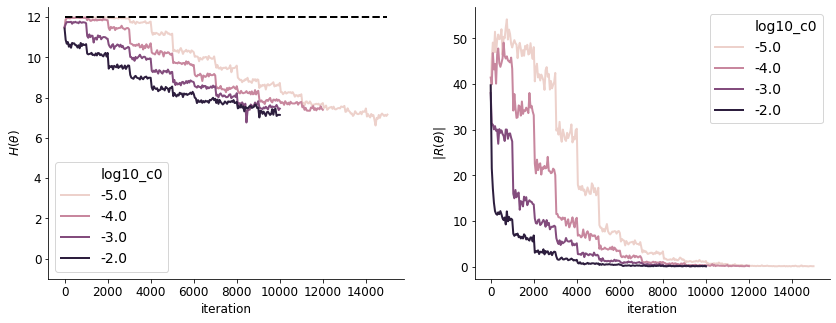

In [16]:
epi_df = M.get_epi_df()
epi_df['log10_c0'] = [np.log10(row['AL_hps']['c0']) for i, row in epi_df.iterrows()]
epi_df['Rnorm'] = [np.linalg.norm([row['R%d' % j] for j in range(1,5)])
                   for i, row in epi_df.iterrows()]
_epi_df = epi_df[epi_df['log10_c0'] < -1]
H_max = -np.log(1/(20.**4))

fig, axs = plt.subplots(1,2,figsize=(14,5))
sns.lineplot(x='iteration', y='H', ax=axs[0], hue='log10_c0', data=_epi_df)
axs[0].set_ylabel(r'$H(\theta)$')
axs[0].set_ylim([-1, 12.5])
axs[0].plot([0, _epi_df['iteration'].max()], [H_max, H_max], 'k--')
sns.lineplot(x='iteration', y='Rnorm', ax=axs[1], hue='log10_c0', data=_epi_df)
axs[1].set_ylabel(r'$|R(\theta)|$')

The effect of `c0` on the EPI optimization is quite evident from the plots above.  Each EPI optimization was run for enough augmented Lagrangian epochs until convergence, with 2,000 iterations per epoch.  
    
We see that low values of `c0` (e.g. `1e-5`) result in fast entropic growth to the uniform distribution at the outset of optimization. (The dashed black line indicates the maximum entropy of a distribution with the given bounds.) Initial entropic growth can be desireable based on the application, however one should expect a greater number of epochs until convergence compared to a greater value of `c0=1`.

However, an important drawback of selecting a high `c0` is that you may miss interesting structure in the learned distribution.